# Stock Market Prediction(Nifty50) using Numerical and Textual Analysis

**Shubham Pandey**

shubham253pro@gmail.com

https://www.linkedin.com/in/shubham-pandey-b93545147/

Date: 12-06-2021

Datasets sourced from

Historical stock prices: https://finance.yahoo.com/

Textual News Headlines: https://bit.ly/36fFPI6

More on Vader : https://realpython.com/python-nltk-sentiment-analysis/

In [111]:
# importing libraries
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

In [112]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Shubham
[nltk_data]     Pandey\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [113]:
# reading the datasets into pandas
price = pd.read_csv('^NSEI.csv')
headlines = pd.read_csv('india-news-headlines.csv')

In [114]:
price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2007-10-17,5658.899902,5658.899902,5107.299805,5559.299805,5559.299805,0.0
1,2007-10-18,5551.100098,5736.799805,5269.649902,5351.000000,5351.000000,0.0
2,2007-10-19,5360.350098,5390.850098,5101.750000,5215.299805,5215.299805,0.0
3,2007-10-22,5202.750000,5247.399902,5070.899902,5184.000000,5184.000000,0.0
4,2007-10-23,5185.299805,5488.500000,5176.850098,5473.700195,5473.700195,0.0


In [115]:
headlines.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


# EDA

Missing Values

In [116]:
print(price.isna().sum())
print('shape -> ',price.shape[0])

Date          0
Open         35
High         35
Low          35
Close        35
Adj Close    35
Volume       35
dtype: int64
shape ->  3369


In [117]:
print(headlines.isna().sum())
print('shape -> ',headlines.shape[0])

publish_date         0
headline_category    0
headline_text        0
dtype: int64
shape ->  3424067


So price has 35 null rows as it appears, it may be due to some national holiday or something. 

In [191]:
35/5204


0.0067255956956187544

Missing data is only 0.6% of total data hence , I will remove it(Moreover those are empty rows so there's no point of imputing them)

In [119]:
price.dropna(inplace=True)

**Price Data**

In [120]:
#drop duplicates
price = price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
price['Date'] = pd.to_datetime(price['Date']).dt.normalize()

# filtering the important columns required
price = price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

price = price.reset_index(drop=True)
price

,Date,Close,Open,High,Low,Volume
0,2007-10-17,5559.299805,5658.899902,5658.899902,5107.299805,0.0
1,2007-10-18,5351.000000,5551.100098,5736.799805,5269.649902,0.0
2,2007-10-19,5215.299805,5360.350098,5390.850098,5101.750000,0.0
3,2007-10-22,5184.000000,5202.750000,5247.399902,5070.899902,0.0
4,2007-10-23,5473.700195,5185.299805,5488.500000,5176.850098,0.0
...,...,...,...,...,...,...
3329,2021-06-07,15751.650391,15725.099609,15773.450195,15678.099609,394000.0
3330,2021-06-08,15740.099609,15773.900391,15778.799805,15680.000000,378200.0
3331,2021-06-09,15635.349609,15766.299805,15800.450195,15566.900391,457900.0
3332,2021-06-10,15737.750000,15692.099609,15751.250000,15648.500000,298300.0


**Headlines data**

In [121]:
# drop duplicates
headlines = headlines.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
headlines['publish_date'] = headlines['publish_date'].astype(str)
headlines['publish_date'] = headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
headlines['publish_date'] = pd.to_datetime(headlines['publish_date']).dt.normalize()

# filtering the important columns required
headlines = headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to 'Date'
headlines = headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

headlines

,publish_date,headline_text
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,"Powerless north India gropes in the dark,Think..."
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...
7259,2020-12-29,Man recovers charred remains of 'thief' from h...
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...


In [122]:
headlines.iloc[0,1]

"Status quo will not be disturbed at Ayodhya; says Vajpayee,Fissures in Hurriyat over Pak visit,America's unwanted heading for India?,For bigwigs; it is destination Goa,Extra buses to clear tourist traffic,Dilute the power of transfers; says Riberio,Focus shifts to teaching of Hindi,IT will become compulsory in schools,Move to stop freedom fighters' pension flayed,Gilani claims he applied for passport 2 years ago,Parivar dismisses PM's warning,India; Pak exchange lists of N-plants,Will Qureshi's return really help the govt?,PM's tacit message: Put Ram tample on hold,Text of the Prime Minister's article,NCW to focus on violence against women,BBC's reality TV will focus on AIIMS,Jaitley firm on legal reforms,Hoshangabad farmers have enough water,BJP jumps into rail track conversion issue,State may take AP to court over Krishna,This official has sued the briber,Park turns temple compound as residents watch,Moves afoot to evict squatters in Urban dist,Mafia calls the shots in Gandhinagar t

In [123]:
data=pd.merge(price,headlines,left_on='Date', right_on='publish_date')

In [124]:
# dropping the null values if any
data.dropna(axis=0, inplace=True)
data.drop('publish_date',axis=1,inplace=True)
data.set_index('Date', inplace= True)
# displaying the combined stock_data
data

,Close,Open,High,Low,Volume,headline_text
Date,,,,,,
2007-10-17,5559.299805,5658.899902,5658.899902,5107.299805,0.0,"Dance festival in Delhi,An Indo-British joint ..."
2007-10-18,5351.000000,5551.100098,5736.799805,5269.649902,0.0,"I'm the first crossover artiste:Kabir,Social r..."
2007-10-19,5215.299805,5360.350098,5390.850098,5101.750000,0.0,"Kat gets the cream,Life's a song for Big B,Son..."
2007-10-22,5184.000000,5202.750000,5247.399902,5070.899902,0.0,"Krishna:From journalist to actor,Icon to share..."
2007-10-23,5473.700195,5185.299805,5488.500000,5176.850098,0.0,"Ash; Hrithik have a royal feel to them,Delhi p..."
...,...,...,...,...,...,...
2020-12-24,13749.250000,13672.150391,13771.750000,13626.900391,471400.0,How to set the mood for sex during cold winter...
2020-12-28,13873.200195,13815.150391,13885.299805,13811.549805,403600.0,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,13932.599609,13910.349609,13967.599609,13859.900391,439600.0,Man recovers charred remains of 'thief' from h...


In [125]:
data['compound'] = ''

In [126]:
# importing requires libraries to analyze the sentiments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

In [127]:
# calculating sentiment scores
data['compound'] = data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound']) #only taking compound

In [128]:
data.drop('headline_text',inplace=True,axis=1)

In [129]:
data

,Close,Open,High,Low,Volume,compound
Date,,,,,,
2007-10-17,5559.299805,5658.899902,5658.899902,5107.299805,0.0,-0.9904
2007-10-18,5351.000000,5551.100098,5736.799805,5269.649902,0.0,-0.9839
2007-10-19,5215.299805,5360.350098,5390.850098,5101.750000,0.0,-0.9994
2007-10-22,5184.000000,5202.750000,5247.399902,5070.899902,0.0,0.9181
2007-10-23,5473.700195,5185.299805,5488.500000,5176.850098,0.0,-0.9937
...,...,...,...,...,...,...
2020-12-24,13749.250000,13672.150391,13771.750000,13626.900391,471400.0,-0.9971
2020-12-28,13873.200195,13815.150391,13885.299805,13811.549805,403600.0,-0.9997
2020-12-29,13932.599609,13910.349609,13967.599609,13859.900391,439600.0,-0.9998


In [130]:
data.sort_index(axis = 0,inplace=True)

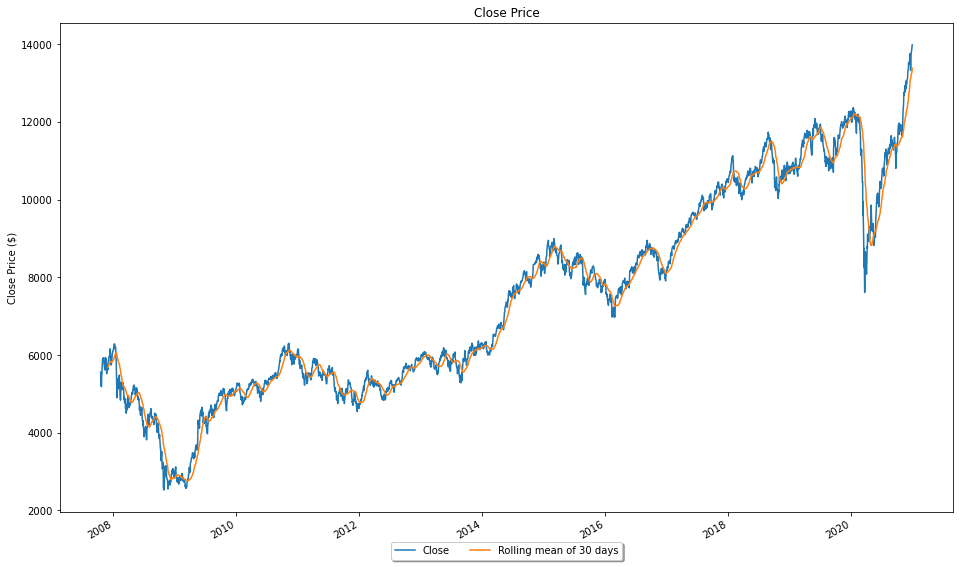

In [131]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting close price
data['Close'].plot(label="Close")

plt.plot(data['Close'].rolling(30).mean(),label="Rolling mean of 30 days")

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)

# Stationary or not?

In [132]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

In [133]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(Close):
    result=adfuller(Close)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


In [134]:
adfuller_test(data['Close'])

ADF Test Statistic : 0.17091950369233863
p-value : 0.9705825729001374
#Lags Used : 12
Number of Observations Used : 3213
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [135]:
data['C_lag1']= data['Close'].shift(1)
data['C_diff']= data['Close'] - data['C_lag1']
data.dropna(inplace=True)

In [136]:
## Again test dickey fuller test
adfuller_test(data['C_diff'].dropna())

ADF Test Statistic : -15.081127585867305
p-value : 8.451518973800805e-28
#Lags Used : 11
Number of Observations Used : 3213
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


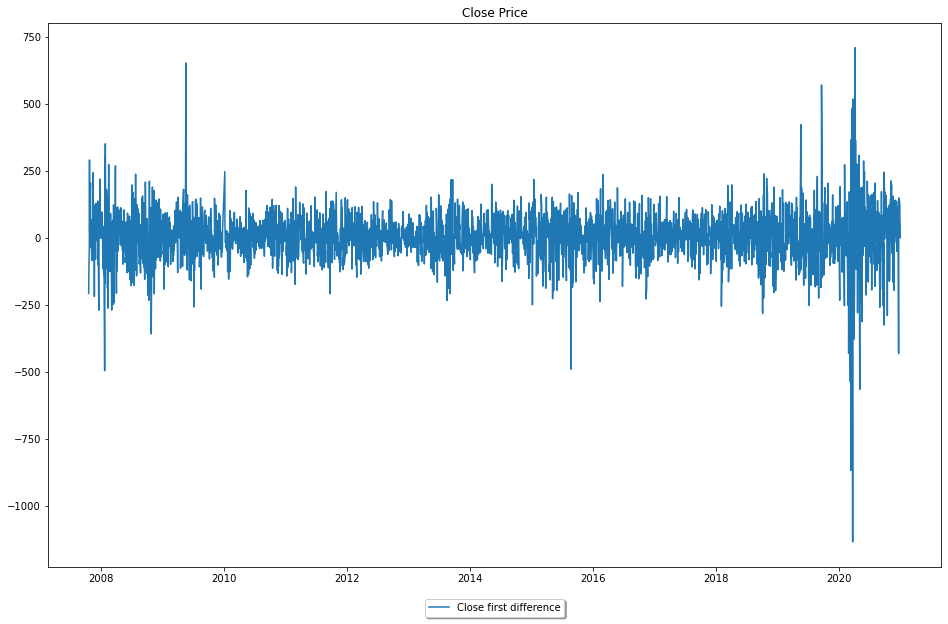

In [137]:
# setting figure size
plt.figure(figsize=(16,10))

plt.plot(data['C_diff'],label="Close first difference")

# setting plot title, x and y labels
plt.title("Close Price")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)

**Mean close to zero -> stationary data** 

but we are not going to use ARIMA model or lagged data.

In [138]:
data.drop(['C_diff','C_lag1'],axis=1,inplace=True)

# Creating Target column

In [139]:
data['Target']= data['Close'].shift(-1)
data.dropna(inplace=True)

**Train-Test split**

In [140]:
X = data.drop('Target',axis=1) 
y= data['Target']

In [141]:
xtrain = X[X.index.year < 2017]
xtest = X[X.index.year > 2017]

ytrain = y[y.index.year < 2017]
ytrain = np.asarray(ytrain).reshape ((ytrain).shape[0], 1)
ytest = y[y.index.year > 2017]
idx = ytest.index
ytest = np.asarray(ytest).reshape ((ytest).shape[0], 1)

In [142]:
cols=data.drop('Target',axis=1).columns
cols

Index(['Close', 'Open', 'High', 'Low', 'Volume', 'compound'], dtype='object')

In [143]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
xtrain = scaler_x.fit_transform(xtrain)

# scaling the feature test dataset
scaler_tx = preprocessing.MinMaxScaler (feature_range=(-1, 1))
xtest = scaler_tx.fit_transform(xtest)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
ytrain = scaler_y.fit_transform(ytrain)

# scaling the target variable
scaler_ty = preprocessing.MinMaxScaler (feature_range=(-1, 1))
ytest = scaler_ty.fit_transform(ytest)

In [179]:
def fit_model(model,xtrain,ytrain,xtest,ytest,idx):
    model =  model
    x_train = xtrain
    y_train = ytrain
    x_test = xtest
    y_test = ytest
    
    model.fit(x_train, y_train)
    sc = model.score(xtrain, ytrain)
    print("Model Score on train set : ",sc)
    pred = model.predict(x_test)
    
    pred = scaler_ty.inverse_transform(np.array(pred).reshape((len(pred), 1)))
    # unscaling the y_test
    y_test = scaler_ty.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))
       
    # calculating root mean squared error
    mse = np.mean(np.power((y_test - pred),2))
    print('Mean Square Error on test set=', round(mse,2))
    
    # calculating R squared error
    r2 = 1-(np.sum(np.power((y_test - pred),2))/np.sum(np.power((y_test - y_test.mean()),2)))
    print('R Squared =', r2.mean())
    

    df_pred = pd.concat([pd.DataFrame(y_test), pd.DataFrame(pred),pd.DataFrame(idx)], axis=1)
    df_pred.columns=['y_test','pred','Date']
    df_pred.set_index('Date',inplace=True)
    
    plt.figure(figsize=(16,10))
    plt.plot(df_pred['pred'], label="Predicted Close Price")
    plt.plot(df_pred['y_test'], label="Testing Close Price")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
    plt.show()

    return pred    

In [180]:
idx.year

Int64Index([2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018,
            ...
            2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020],
           dtype='int64', name='Date', length=735)

# **Linear Regression**

Model Score on train set :  0.9975481620845456
Mean Square Error on test set= 18246.77
R Squared = 0.9790287858713513


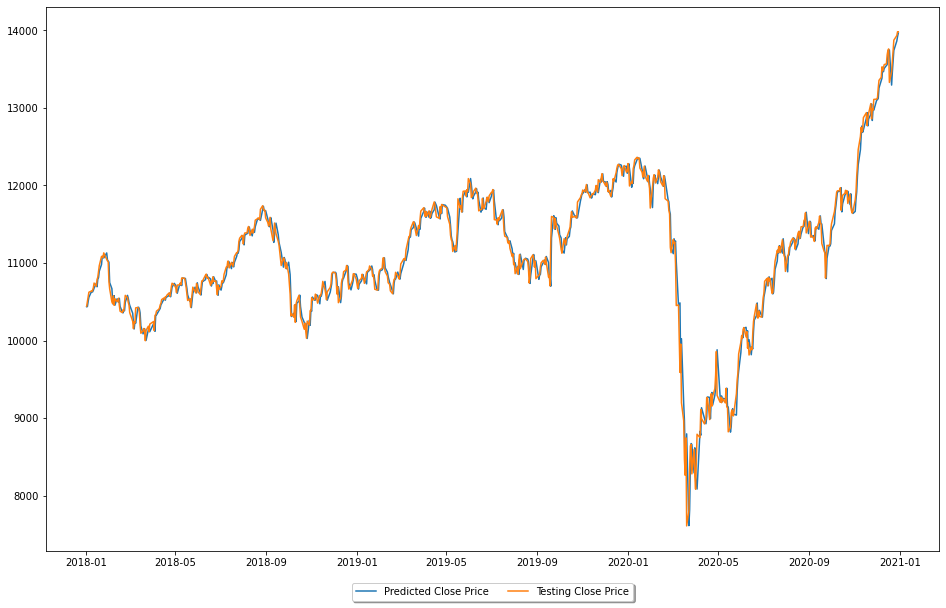

In [181]:
p=fit_model(LinearRegression(),xtrain,ytrain,xtest,ytest,idx)

# **XGBRegressor**

Model Score on train set :  0.9996189351485465
Mean Square Error on test set= 19359.9
R Squared = 0.977749462065798


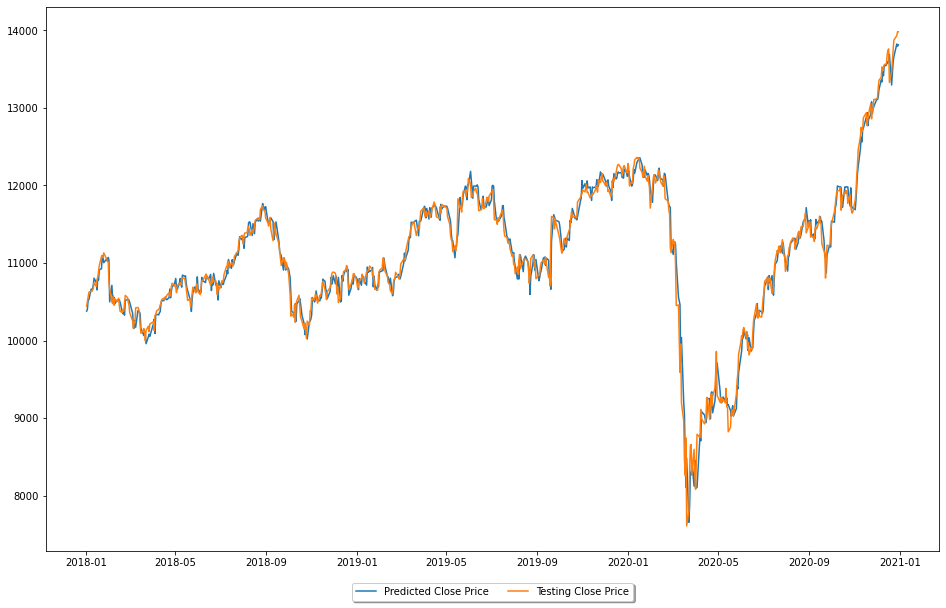

In [182]:
p=fit_model(xgb.XGBRegressor(),xtrain,ytrain,xtest,ytest,idx)

# **Random Forest**

Model Score on train set :  0.9995644714456955
Mean Square Error on test set= 20197.25
R Squared = 0.9767870836283791


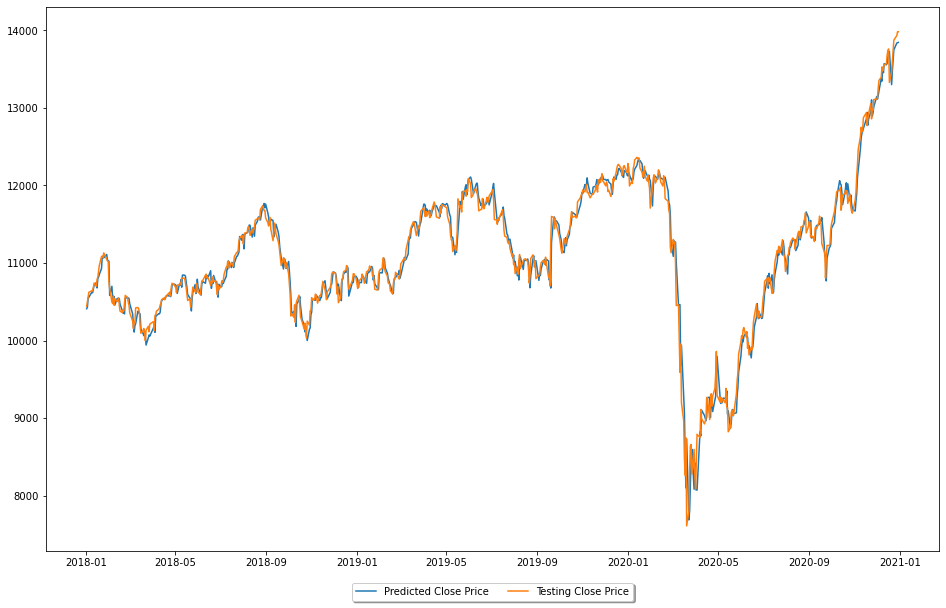

In [183]:
p=fit_model(RandomForestRegressor(),xtrain,ytrain,xtest,ytest,idx)

# Above we have not only predicted the stock prices but also **proved** that complex model is not always the best model.

# The solution should be a balance of great accuracy and economically feasible approach.

# In real life you can't afford to improve 0.001 accuracy in your prediction by adding cost (in millions) to implement more complex models, like people do in **Kaggle competitions**(no offence but that's true 😂).